# Loading Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, TensorDataset
from torchvision.models import resnet18 
import catboost as cb
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Improved device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M1/M2 GPU")
else:
    device = torch.device("cpu")
    print("Warning: Using CPU - No GPU acceleration available")

# This will suppress the tqdm warning
from tqdm.auto import tqdm
tqdm.pandas()

# OASIS-1 Information: Shape, Missing Values, and Duplicates

In [2]:
# Load OASIS-1 dataset
df = pd.read_excel('oasis_cross-sectional.xlsx')

# Display basic information for OASIS-1
print("OASIS-1 Data Shape:", df.shape)
display(df.head())
display(df.info())

# Check for missing values in OASIS-1
missing_values1 = df.isnull().sum()
print("OASIS-1 Missing Values:\n", missing_values1[missing_values1 > 0])

# Check for duplicates in OASIS-1
duplicates1 = df.duplicated().sum()
print("OASIS-1 Number of duplicate rows:", duplicates1)

OASIS-1 Data Shape: (436, 12)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


None

OASIS-1 Missing Values:
 Educ     201
SES      220
MMSE     201
CDR      201
Delay    416
dtype: int64
OASIS-1 Number of duplicate rows: 0


As can be seen above, for Oasis-1, there is a large amount of missing values for Educ, SES, MMSE, CDR, and Delay. The datatype used is int64 for Age and eTIV, float64 for Educ, SES, MMSE, CDR, nWBV, ASF, and Delay, while ID, M/F, and Hand are objects. The shape is (436, 12) and there are no duplicate rows. Overall, there are 436 different entries for 12 different attributes.

# Oasis-1 Class Distribution

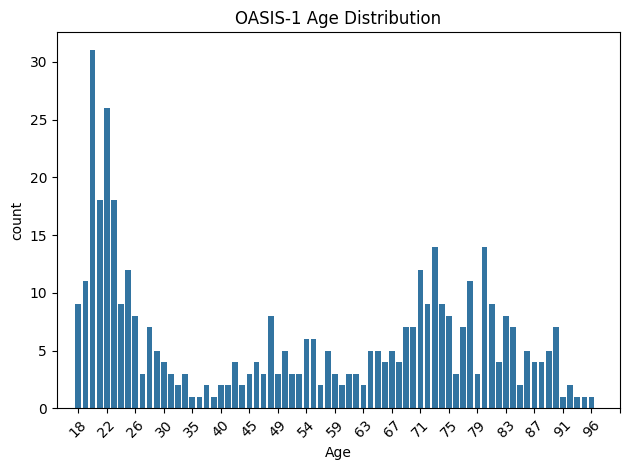

In [3]:

# Age distribution in OASIS-1
class_column1 = df.columns[3]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Age Distribution")

# Set x-axis limits and ticks from 20 to 100
plt.xlim(-3, 10)
plt.xticks(ticks=range(0, 77, 4), rotation=45)

plt.tight_layout()
plt.show()


# Class Distribution

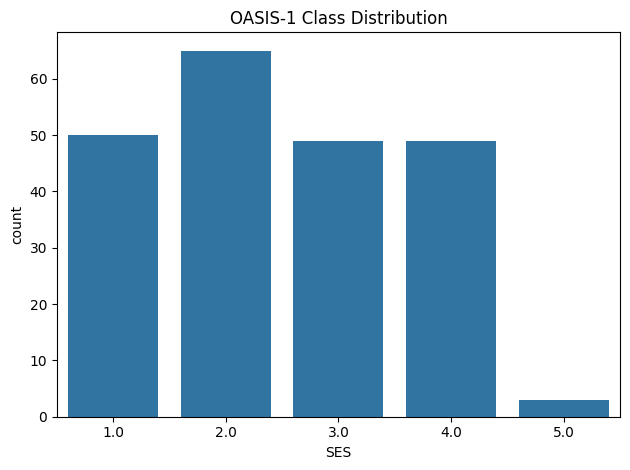

In [4]:
# Age distribution in OASIS-1
class_column1 = df.columns[5]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Class Distribution")

plt.tight_layout()
plt.show()

# OASIS-1 Summary Statistics and Histogram

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


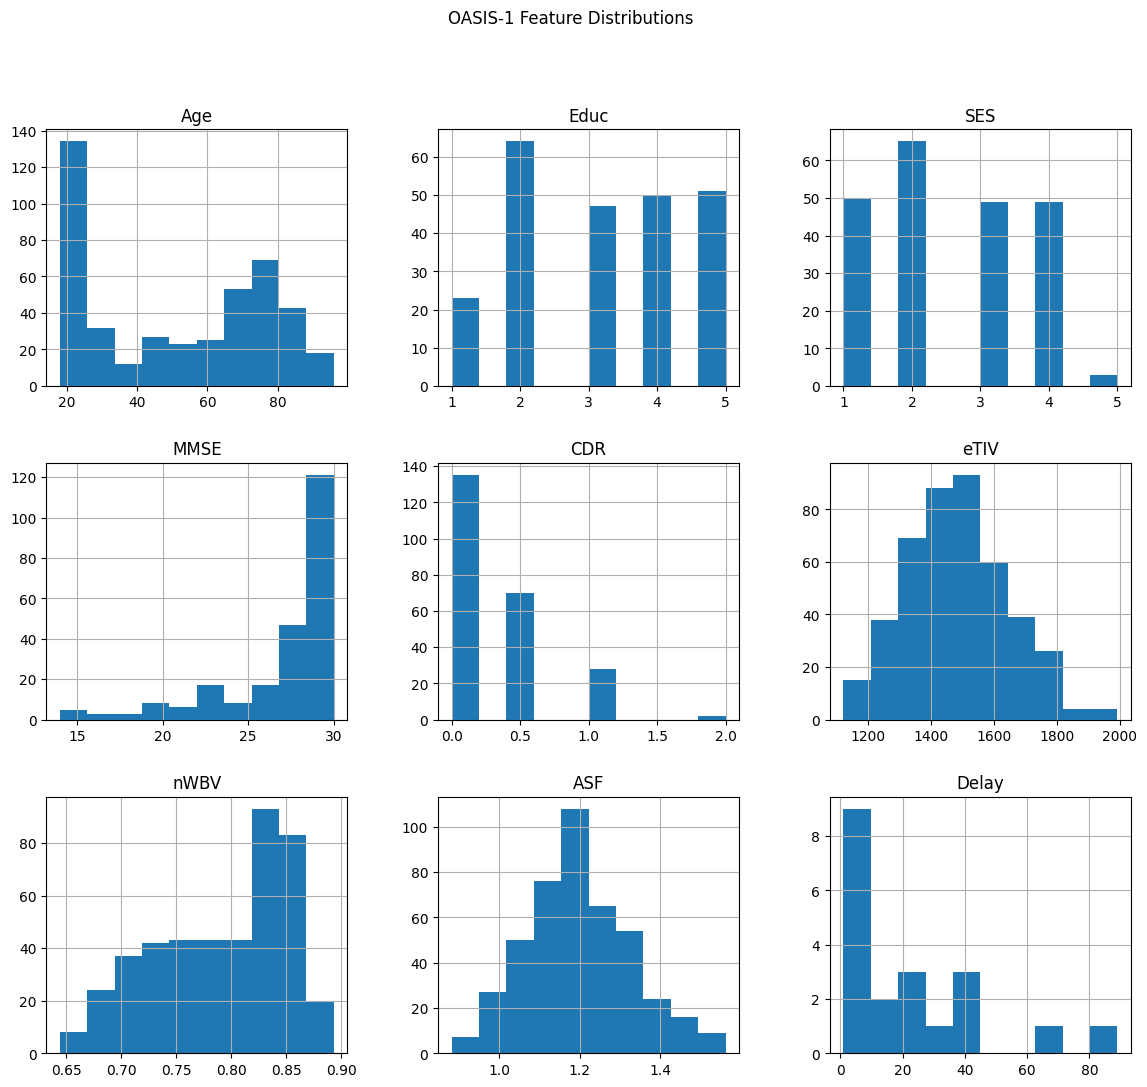

In [5]:
# Display summary statistics for OASIS-1
display(df.describe())

# Histograms for numerical features in OASIS-1
df.hist(figsize=(14, 12))
plt.suptitle("OASIS-1 Feature Distributions")
plt.show()


Naturally, due to the nature of the different attributes, there are different values for each. The attributes that are objects are not included due to this. For those represented, a lot of trends can be gleaned. A staggering number of participants are young, but a good amount of older folks were tested too, explaining the mean of 51 and standard deviation of 25. Education is by education level, but this is incomplete and much harder to analyze. For the most part, the socioeconomic statuses are equal, which a minority being the richest. The MMSE is the mini-mental state examination, with the large number of 30s being expected, as this is a perfect score and thus shows someone who retains their mental acuity. The lower scores show those that are potentially demented. Accordingly, the CDR is the clinical dementia rating, with the rating mostly showing people with zeroes, which implies no dementia. The higher scores show those rated to be demented. ASF, nWBV, and eTIV are all attributes describing the brain volume, which can be supposed to measure atrophy in outliers. Accordingly, eTIV and ASF are mostly uniform, while nWBV is skewed towards the higher end, while still having many values 0.644 and above. The delay being practically nonexistent makes sense, as this is how much a person delayed since the last visit. If most people are irrelevant to this, then this will not be included for them.

# Oasis-1 Boxplots and Correlation Matrix

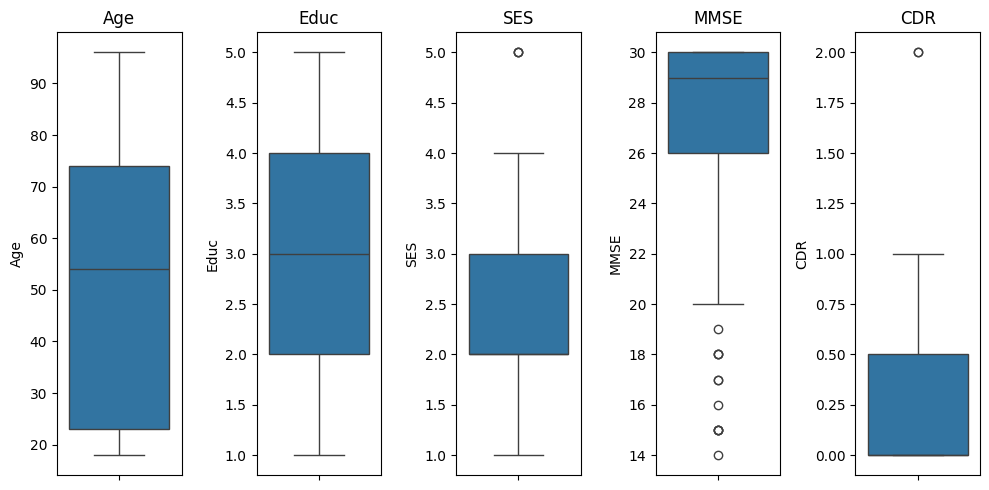

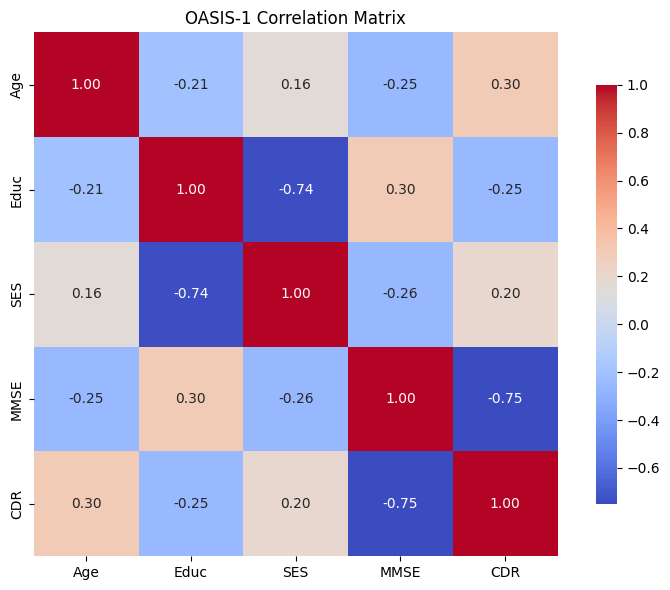

In [6]:
# Boxplots and subplots for features in OASIS-1
plt.figure(figsize=(10, 5))
num_cols1 = df.select_dtypes(include=np.number).columns
num_cols1 = num_cols1.dropna()  # Drop any NaN columns if they exist
num_cols1 = num_cols1[num_cols1 != 'age']  # Exclude 'age' if it's not needed
num_cols1 = num_cols1[:5]  # Limit to first 8 numerical columns for clarity
for i, col in enumerate(num_cols1):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

# Check for correlations in OASIS-1
correlation_matrix1 = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(8, 6))
# Limit the correlation matrix to the first 5 numerical columns for clarity
correlation_matrix1 = correlation_matrix1.iloc[:5, :5]  # Limit to first 5 numerical columns
sns.heatmap(correlation_matrix1, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("OASIS-1 Correlation Matrix")
plt.tight_layout()
plt.show()



# Class for MRI Dataset



In [7]:
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  # Ensure clean indices
        self.transform = transform
        self.class_weights = self._calculate_class_weights()
        
    def _calculate_class_weights(self):
        class_counts = self.df['label_idx'].value_counts().sort_index().values
        return 1. / torch.tensor(class_counts, dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx >= len(self):  # Safety check
            idx = idx % len(self)
            
        row = self.df.iloc[idx]
        img_path = row['image_path']
        
        try:
            image = Image.open(img_path).convert('RGB')
            label = row['label_idx']
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return zero tensor and majority class as fallback
            return torch.zeros(3, 224, 224), 0

# Loading In Images

Image Categories: ['.DS_Store', 'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia']
Image Data Shape: (86437, 2)


,image_path,label
0,Data\Mild Dementia\OAS1_0028_MR1_mpr-1_100.jpg,Mild Dementia
1,Data\Mild Dementia\OAS1_0028_MR1_mpr-1_101.jpg,Mild Dementia
2,Data\Mild Dementia\OAS1_0028_MR1_mpr-1_102.jpg,Mild Dementia
3,Data\Mild Dementia\OAS1_0028_MR1_mpr-1_103.jpg,Mild Dementia
4,Data\Mild Dementia\OAS1_0028_MR1_mpr-1_104.jpg,Mild Dementia


Image Data Missing Values:
 Series([], dtype: int64)
Image Data Number of duplicate rows: 0


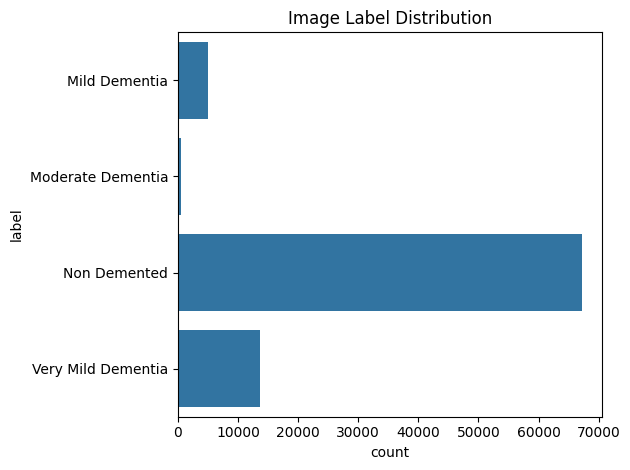

In [8]:
# From the Data folder, get all the images
image_folder = "Data"
folder_categories = os.listdir(image_folder)
# Display the folder categories
print("Image Categories:", folder_categories)
# Load images and labels into a DataFrame
image_data = []
for category in folder_categories:
    category_path = os.path.join(image_folder, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_data.append({
                    "image_path": os.path.join(category_path, filename),
                    "label": category
                })
                
# Convert to DataFrame
image_df = pd.DataFrame(image_data)

# Display the first few rows of the image DataFrame
print("Image Data Shape:", image_df.shape)
display(image_df.head())

# Check for missing values in image DataFrame
missing_values_images = image_df.isnull().sum()
print("Image Data Missing Values:\n", missing_values_images[missing_values_images > 0])

# Check for duplicates in image DataFrame
duplicates_images = image_df.duplicated().sum()
print("Image Data Number of duplicate rows:", duplicates_images)

# Display the distribution of image labels
sns.countplot(y='label', data=image_df)
plt.title("Image Label Distribution")
plt.tight_layout()
plt.show()

# Define Transformations


In [9]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
        image = transform(image)  # Apply transformations
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Preprocess the images
**PLEASE PLEASE PLEASE**
DONT FORGET TO CHANGE THE FRACTION OF HOW MUCH THE DATABASE IS USED, ITS 1% FOR BASIC TESTING ON MACBOOKS

In [10]:
# Take 5% of the image data for training
image_df = image_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
# Display the shape of the sampled image DataFrame
print("Sampled Image Data Shape:", image_df.shape)

# Load and preprocess all images
images = []
labels = []

for index, row in image_df.iterrows():
    image_path = row['image_path']
    label = row['label']
    image_tensor = load_and_preprocess_image(image_path)
    if image_tensor is not None:
        images.append(image_tensor)
        labels.append(label)
# Convert lists to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(pd.factorize(labels)[0])  # Factorize labels to numeric values

# Create a TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Sampled Image Data Shape: (8644, 2)


C:\Users\austi\AppData\Local\Temp\ipykernel_107952\1942175920.py:19: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  labels_tensor = torch.tensor(pd.factorize(labels)[0])  # Factorize labels to numeric values


# Define the CNN Portion

In [11]:
class MRICNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MRICNN, self).__init__()
        self.resnet = resnet18(pretrained=True)  # Load pre-trained ResNet-18 model
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Modify the final layer

    def forward(self, x):
        return self.resnet(x)

# Function to replace inplace ReLU with non-inplace ReLU
# This is necessary for SHAP and CatBoost compatibility
def replace_relu_inplace(module):
    for child_name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, child_name, nn.ReLU(inplace=False))
        else:
            replace_relu_inplace(child)

print("Unique image labels:", image_df['label'].unique())
print("Image label distribution:\n", image_df['label'].value_counts())

Unique image labels: ['Non Demented' 'Mild Dementia' 'Very Mild Dementia' 'Moderate Dementia']
Image label distribution:
 label
Non Demented          6804
Very Mild Dementia    1314
Mild Dementia          476
Moderate Dementia       50
Name: count, dtype: int64


# Initialize Training Variables

In [12]:
# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(image_df['label'].unique())
model = MRICNN(num_classes).to(device)
replace_relu_inplace(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
val_losses = []

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definitions for Training and Evaluation

In [13]:
# Define the training process
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        # Store the average loss for plotting
        losses.append(avg_loss)

        # Store the validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)
                val_loss += v_loss.item()
        avg_val_loss = val_loss / len(val_dataloader)

        # Store the average validation loss for plotting
        val_losses.append(avg_val_loss)

        # Store training accuracy 
        _, preds = torch.max(outputs, 1)
        train_accuracy = (preds == labels).float().mean().item()

        # Store validation accuracy
        val_preds = torch.max(val_outputs, 1)[1]
        val_accuracy = (val_preds == val_labels).float().mean().item()

        # Print the average loss and accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# Evaluate the model on the training set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


# Training the CNN Model


In [14]:
# Train the model
train_model(model, train_dataloader, criterion, optimizer, num_epochs=10)
# Evaluate the model on the training set
train_preds, train_labels = evaluate_model(model, train_dataloader)
# Evaluate the model on the validation set
val_preds, val_labels = evaluate_model(model, val_dataloader)

Epoch 1/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.4828, Val Loss: 0.7615, Train Acc: 0.6667, Val Acc: 1.0000


Epoch 2/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.7813, Val Loss: 0.6639, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 3/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.6780, Val Loss: 0.6720, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 4/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.6751, Val Loss: 0.6656, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 5/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.6734, Val Loss: 0.6676, Train Acc: 1.0000, Val Acc: 0.0000


Epoch 6/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.6739, Val Loss: 0.6707, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 7/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6765, Val Loss: 0.6616, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 8/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.6719, Val Loss: 0.6651, Train Acc: 1.0000, Val Acc: 0.0000


Epoch 9/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6764, Val Loss: 0.6669, Train Acc: 0.6667, Val Acc: 0.0000


Epoch 10/10:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6752, Val Loss: 0.6715, Train Acc: 1.0000, Val Acc: 0.0000


Evaluating:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

# Visualize Epochs vs. Predictions

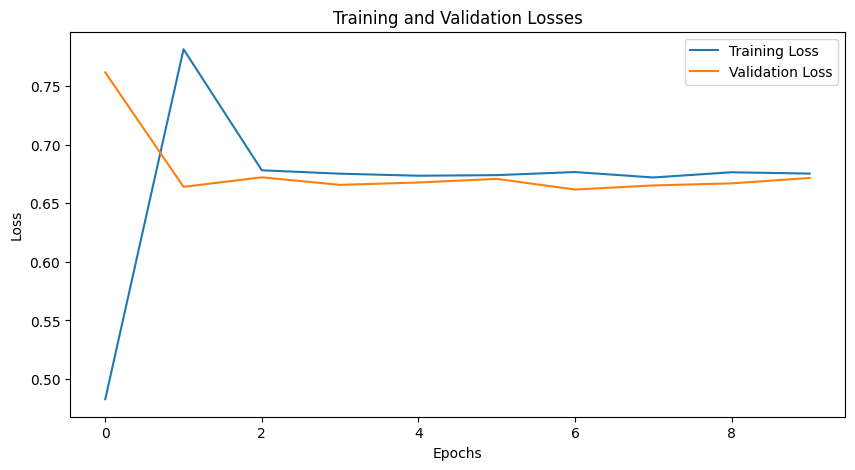

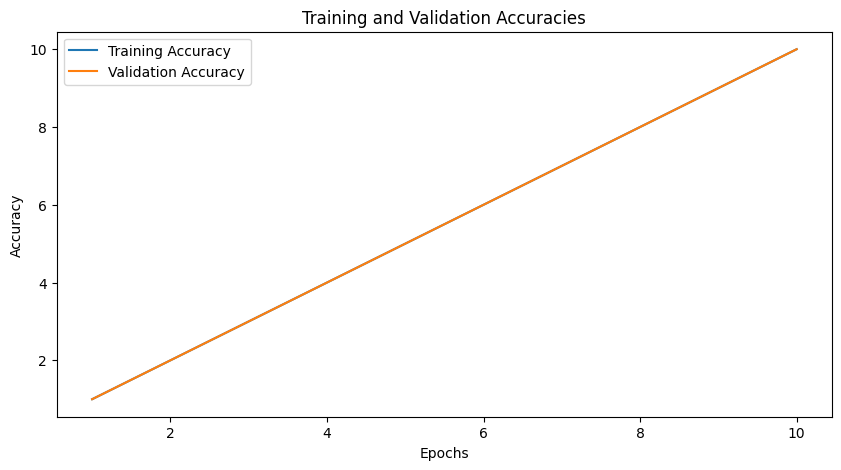

In [15]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot([x for x in range(1, len(losses) + 1)], [x for x in range(1, len(losses) + 1)], label='Training Accuracy')
plt.plot([x for x in range(1, len(val_losses) + 1)], [x for x in range(1, len(val_losses) + 1)], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()



# Saving and Loading the Model for Future use

In [16]:
# Save model 
torch.save(model.state_dict(), 'mri_cnn_model.pth')

# Load the model for inference
model = MRICNN(num_classes).to(device)
model.load_state_dict(torch.load('mri_cnn_model.pth'))
model.eval()

MRICNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

# Displaying some images and predictions of CNN Model

Image: Data\Non Demented\OAS1_0348_MR1_mpr-3_142.jpg, Predicted Class: Non Demented, Actual Class: Non Demented


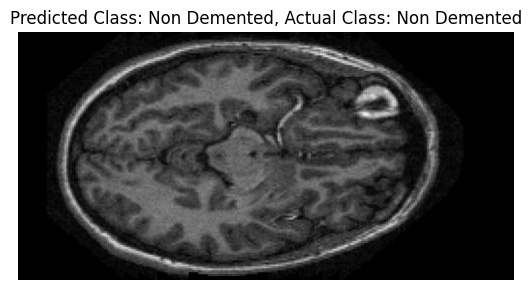

Image: Data\Non Demented\OAS1_0345_MR1_mpr-2_101.jpg, Predicted Class: Non Demented, Actual Class: Non Demented


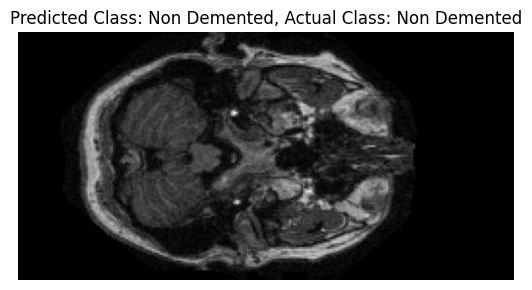

Image: Data\Non Demented\OAS1_0019_MR1_mpr-4_124.jpg, Predicted Class: Non Demented, Actual Class: Non Demented


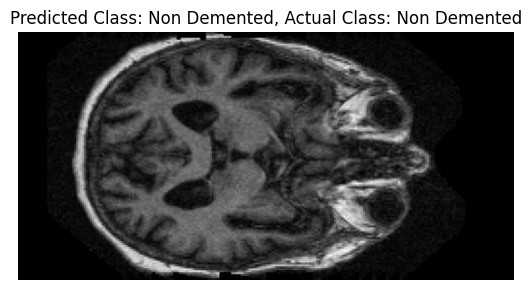

Image: Data\Non Demented\OAS1_0138_MR1_mpr-2_114.jpg, Predicted Class: Non Demented, Actual Class: Non Demented


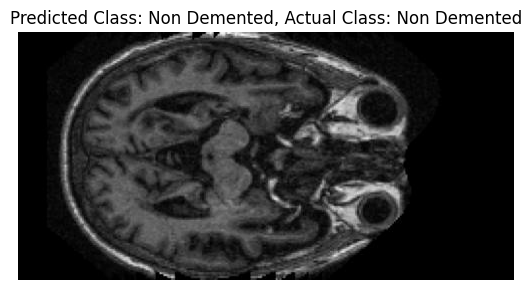

Image: Data\Non Demented\OAS1_0279_MR1_mpr-3_158.jpg, Predicted Class: Non Demented, Actual Class: Non Demented


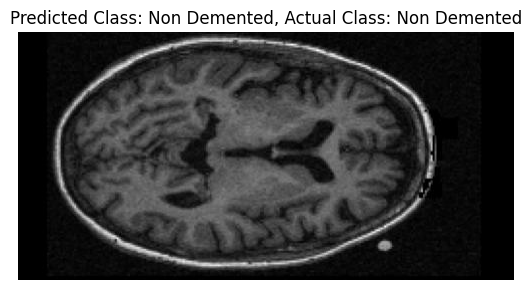

In [17]:
# Function to predict the class of an image using the trained model
def predict_image_class(model, image_path):
    image = load_and_preprocess_image(image_path)
    if image is not None:
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
            return predicted.item()
    else:
        return None
    
# Showing 5 predictions on 5 random images
for i in range(5):
    random_image = image_df.sample(1).iloc[0]
    image_path = random_image['image_path']
    predicted_class = predict_image_class(model, image_path)
    predicted_label = image_df['label'].unique()[predicted_class]
    print(f"Image: {image_path}, Predicted Class: {predicted_label}, Actual Class: {random_image['label']}")
# Display the image
    img = Image.open(image_path).convert('RGB')
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}, Actual Class: {random_image['label']}")
    plt.axis('off')
    plt.show()


# Confusion Matrix:

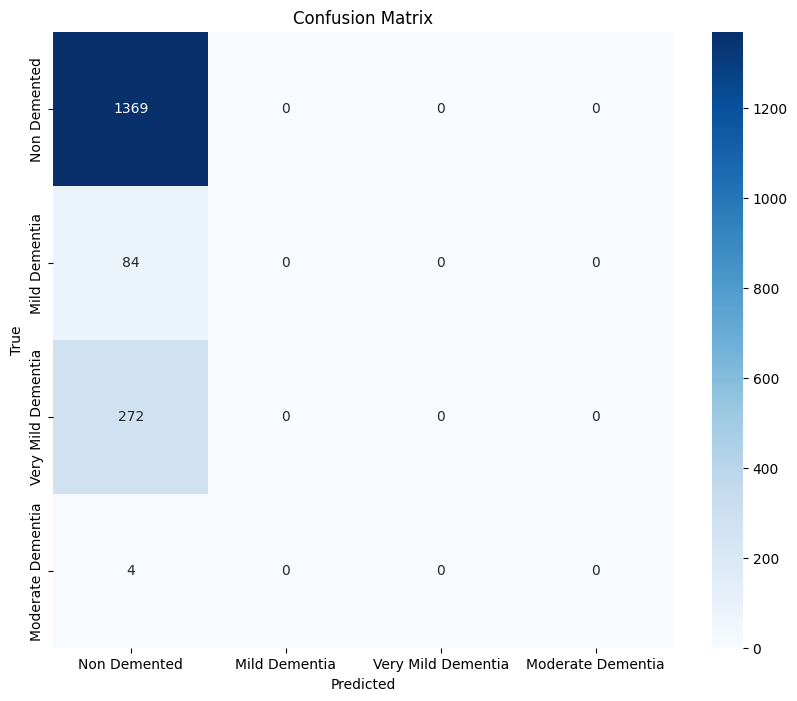

Classification Report (Training Set):
                    precision    recall  f1-score   support

      Non Demented       0.79      1.00      0.88      5435
     Mild Dementia       0.00      0.00      0.00       392
Very Mild Dementia       0.00      0.00      0.00      1042
 Moderate Dementia       0.00      0.00      0.00        46

          accuracy                           0.79      6915
         macro avg       0.20      0.25      0.22      6915
      weighted avg       0.62      0.79      0.69      6915

Classification Report (Validation Set):
                    precision    recall  f1-score   support

      Non Demented       0.79      1.00      0.88      1369
     Mild Dementia       0.00      0.00      0.00        84
Very Mild Dementia       0.00      0.00      0.00       272
 Moderate Dementia       0.00      0.00      0.00         4

          accuracy                           0.79      1729
         macro avg       0.20      0.25      0.22      1729
      weighted av

c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
# Create a confusion matrix for the validation set
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the validation set and create a confusion matrix
def evaluate_model_with_confusion_matrix(model, dataloader):
    all_labels = []
    all_preds = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Get the class names from the image DataFrame
class_names = image_df['label'].unique()
# Evaluate the model and plot the confusion matrix
y_true, y_pred = evaluate_model_with_confusion_matrix(model, val_dataloader)
plot_confusion_matrix(y_true, y_pred, class_names)
# Display classification report for training set
print("Classification Report (Training Set):")
print(classification_report(train_labels, train_preds, target_names=image_df['label'].unique()))
# Display classification report for validation set
print("Classification Report (Validation Set):")
print(classification_report(val_labels, val_preds, target_names=image_df['label'].unique()))

